In [61]:
!cd ../data/ && git clone https://github.com/uakarsh/sample_rvl_cdip_dataset.git
!find '../data/sample_rvl_cdip_dataset/IDL Pre-training dataset/ocrs' -type f > ../data/ocr_files.txt

fatal: destination path 'sample_rvl_cdip_dataset' already exists and is not an empty directory.


In [1]:
import os
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from utils_data_prep import download_and_store_pdf, get_image_ocrs_dict_from_path
import pandas as pd
from typing import List

# For reading the PDFs
from PyPDF2 import PdfReader
import io
from PIL import Image, ImageDraw
import json

/Users/akarsh.upadhyay@zomato.com/anaconda3/envs/docformer-v2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0. Downloading PDF

In [2]:
if __name__ == '__main__':
    with open("../data/ocr_files.txt") as x:
        alist = [line.rstrip() for line in x]
    alist = list(map(lambda x : os.path.join("../data", x), alist))
    total_length = len(alist)

    
    print(f"Total files are {total_length}")
    ## For each entry in the list, download the pdf using joblib and download_and_store_pdf
    out = 0
    batch = 100
    for i in tqdm(range(0, total_length, batch), total = total_length//batch):
        ## Parallelize the below function
        sample_output =  Parallel(n_jobs= -1, backend = "multiprocessing")(delayed(download_and_store_pdf)(alist[j]) for j in range(i, min(i+batch, total_length)))
        # print("sample_output", sample_output)
        out += sum(sample_output)
        # out += download_and_store_pdf(alist[i])
    
    print(f"Total files downloaded are {out}")
    print(f"Total files not downloaded are {total_length - out}, and in percentage {(total_length - out)/total_length * 100} %")

Total files are 1


1it [00:00,  1.01it/s]

Total files downloaded are 1
Total files not downloaded are 0, and in percentage 0.0 %


In [3]:
if not os.path.exists("../data/pdf_files.txt"):
    !find '../data/sample_rvl_cdip_dataset/IDL Pre-training dataset/pdfs' -type f > ../data/pdf_files.txt

### 1. Check the intersection of OCR's and PDF's (name can be ocr_pdf_file_intersection.py)

Since, there can be times when the PDF's haven't been downloaded, let's create a CSV file, for which both the json and the pdf path exists

In [4]:
if not os.path.exists("../data/ocr_pdf.csv"):
    ## read lines from a text file named ocr_files.txt and store it in a set

    with open("../data/ocr_files.txt", "r") as f:
        ocrs = f.readlines()
        ocrs = [line.strip().replace("ocrs", "*").replace(".json", "") for line in ocrs]

    ## create a set of the lines
    ocrs = set(ocrs)

    with open("../data/pdf_files.txt", "r") as f:
        pdfs = f.readlines()
        pdfs = [line.strip().replace("pdfs", "*").replace(".pdf", "") for line in pdfs]

    ## create a set of the lines
    pdfs = set(pdfs)

    ## intersection of pdfs and ocrs
    intersection = pdfs.intersection(ocrs)

    pdf_path = []
    ocr_path = []

    for i in intersection:
        pdf_path.append(i.replace("*", "pdfs") + ".pdf")
        ocr_path.append(i.replace("*", "ocrs") + ".json")

    df = pd.DataFrame({"pdf_path": pdf_path, "ocr_path": ocr_path})
    df.to_csv("../data/ocr_pdf.csv", index=False)

### Heads up -> Until now, we have been able to download the PDF files corresponding to the JSON files using Joblib. Now, we need to prepare the data in an image + OCR manner, so that we can keep it in a format, our model needs


### 3. Prepare the IDL Dataset from Path

In [5]:
if __name__ == "__main__" and (not os.path.exists("../data/true_data_path.csv")):
        csv_path = '../data/ocr_pdf.csv'
        df = pd.read_csv(csv_path)
        
        pdf_path = df.pdf_path.values.tolist()
        ocr_path = df.ocr_path.values.tolist()

        img_list = []
        ocr_list = []

        pdf_files = sorted(pdf_path)
        ocr_files = sorted(ocr_path)

        img_list = []
        ocr_list = []
        pg_list = []

        step_size = 100
        for i in tqdm(range(0, len(pdf_files), step_size), total = len(pdf_files) // step_size):
            entries = Parallel(n_jobs=-1, backend="multiprocessing")(delayed(get_image_ocrs_dict_from_path)
                                                                          (pdf_file_path=pdf_files[i],
                                                                        ocr_file_path=ocr_files[i])
                                                                          for i in range(i, min(i+step_size, len(pdf_files))))
            for entry in entries:
                img, ocrs = entry
                for key in list(img.keys()):
                    if key in ocrs:
                        img_list.append(img[key])
                        ocr_list.append(ocrs[key])
                        pg_list.append(key)

        df = pd.DataFrame({"img_list" : img_list, "ocr_list" : ocr_list, "pg_num" : pg_list})
        df.to_csv("../data/true_data_path.csv", index = False)

        print(
            f"Total length of images and ocrs are : {len(img_list)} and {len(ocr_list)} respectively.")

### 4. Visualizing Bounding Boxes

In [25]:
def normalize_box(box : List[int], width : int, height : int, size : tuple = (1000, 1000)):
    """
    Takes a bounding box and normalizes it to a thousand pixels. If you notice it is
    just like calculating percentage except takes 1000 instead of 100.
    """
    return [
        int(size[0] * (box[0] / width)),
        int(size[1] * (box[1] / height)),
        int(size[0] * (box[2] / width)),
        int(size[1] * (box[3] / height)),
    ]


def get_img_bounding_box(pdf_path : str, ocr_path : str, pg_num : int):
  
  ## Creating a blank white image  
  reader = PdfReader(pdf_path)
  page = list(reader.pages)[pg_num]
  image_file_object = page.images[0]
  stream = io.BytesIO(image_file_object.data)
  img = Image.open(stream).convert("RGB")#.resize((1000, 1000))
  
  json_entry = json.load(open(ocr_path))[1]
  json_entry = [x for x in json_entry["Blocks"] if "Text" in x and (x["Page"] -1 == pg_num)]
  words = []
  bounding_boxes = []
    
  for entry in json_entry:
      bbox = entry["Geometry"]["BoundingBox"]
      x, y, w, h = bbox['Left'], bbox['Top'], bbox["Width"], bbox["Height"]
      bbox = [x, y, x + w, y + h]
      bbox = normalize_box(bbox, width=1, height=1, size= (1000, 1000))
      # if entry["Page"] == pg_num + 1:
      words.append(entry['Text'])
      bounding_boxes.append(bbox)
      #ocr.append({"word": entry["Text"], "bbox": bbox})

  return {'img' : img.resize((1000, 1000)), 'bbox' : bounding_boxes, 'words' : words}

In [26]:
df = pd.read_csv("../data/true_data_path.csv")

train_examples = {'img' : [], 'bbox' : [], 'words' : []}
for idx in range(len(df)):
    sample = df.iloc[idx]
    item = get_img_bounding_box(pdf_path = sample['img_list'], ocr_path = sample['ocr_list'], pg_num = sample['pg_num'])
    
    for key in train_examples:
        train_examples[key].append(item[key])

In [27]:
from datasets import DatasetDict, Dataset, load_from_disk
raw_datasets = DatasetDict({'train':Dataset.from_dict(train_examples)})
raw_datasets.save_to_disk("../data/idl-pretrain-dataset")
raw_datasets = load_from_disk("../data/idl-pretrain-dataset")

Saving the dataset (1/1 shards): 100%|██████████| 2/2 [00:00<00:00, 967.54 examples/s] 


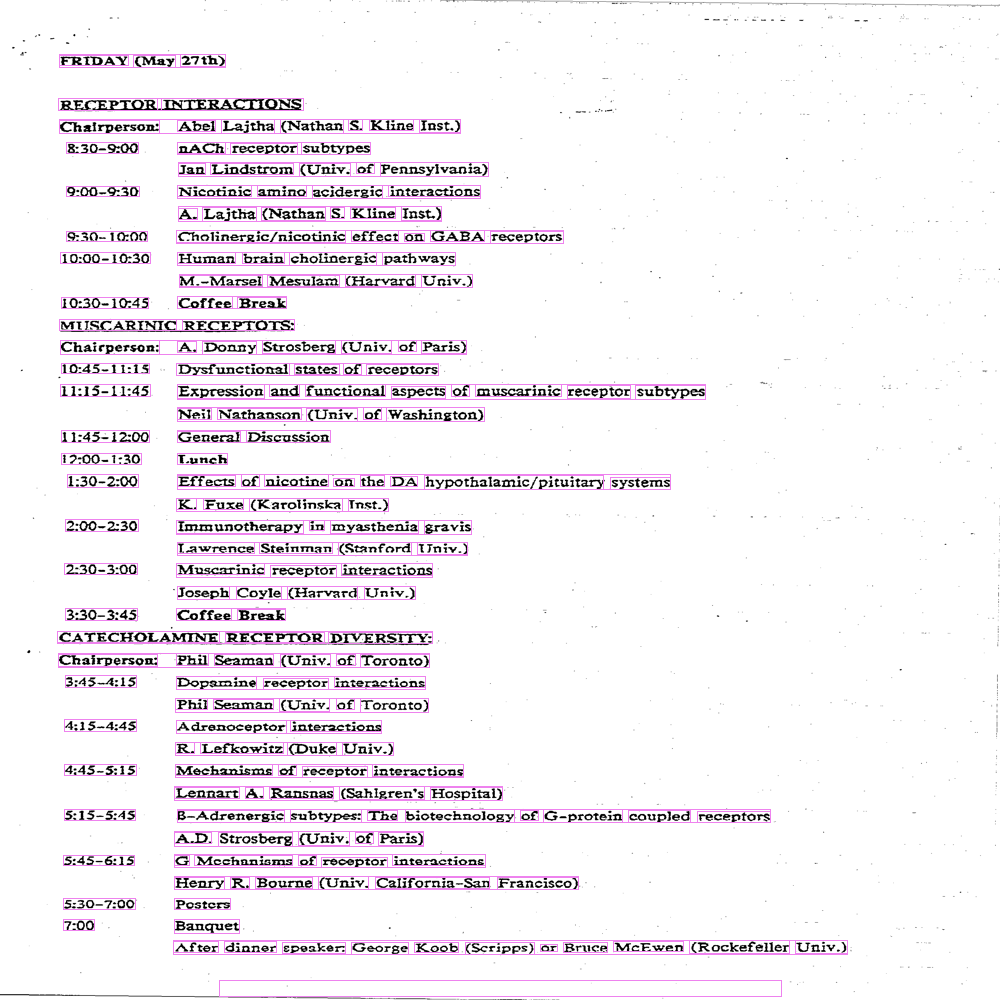

In [28]:
item = raw_datasets['train'][0]
# create rectangle image
img = item['img']
bbox = item['bbox'][:-1] ## Removing the website
words = item['words'][:-1] ## Removing the website
draw_on_img = ImageDraw.Draw(img)  

for it in bbox:
  draw_on_img.rectangle(it, outline ="violet")
img

In [1]:
img.size

NameError: name 'img' is not defined